In [30]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, mean_absolute_error
from scipy.stats import uniform

#### Data Preprocessing

In [31]:
df = pd.read_csv('../cleaning-preprocessing/flight-delay-dataset.csv')

In [32]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28820 entries, 0 to 28819
Data columns (total 23 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   MONTH              28820 non-null  int64  
 1   DAY_OF_MONTH       28820 non-null  int64  
 2   DAY_OF_WEEK        28820 non-null  int64  
 3   OP_UNIQUE_CARRIER  28820 non-null  object 
 4   TAIL_NUM           28820 non-null  object 
 5   DEST               28820 non-null  object 
 6   DEP_DELAY          28820 non-null  int64  
 7   CRS_ELAPSED_TIME   28820 non-null  int64  
 8   DISTANCE           28820 non-null  int64  
 9   CRS_DEP_M          28820 non-null  int64  
 10  DEP_TIME_M         28820 non-null  int64  
 11  CRS_ARR_M          28820 non-null  int64  
 12  Temperature        28820 non-null  int64  
 13  Dew Point          28820 non-null  object 
 14  Humidity           28820 non-null  int64  
 15  Wind               28818 non-null  object 
 16  Wind Speed         288

In [33]:
# Remove NAs
df.isna().sum()
df.dropna(inplace=True)

In [34]:
# No duplicates
df.duplicated().value_counts()

False    28818
Name: count, dtype: int64

In [35]:
# Remove TAIL_NUM and TAXI_OUT
df.drop(columns=['TAIL_NUM', 'TAXI_OUT', 'DEP_TIME_M'], inplace=True)

In [36]:
# Convert DEW_POINT to int
df['Dew Point'] = df['Dew Point'].astype(int)

In [37]:
# Encode categorical variables
columns_to_encode = ['OP_UNIQUE_CARRIER', 'DEST', 'Wind', 'Condition']
df_encoded = pd.get_dummies(df, columns=columns_to_encode)

In [38]:
# Remove all values beyond 3 standard deviations from the mean
mean_dep_delay = df_encoded['DEP_DELAY'].mean()
std_dep_delay = df_encoded['DEP_DELAY'].std()
upper_threshold = mean_dep_delay + (3 * std_dep_delay)
df_encoded = df_encoded[df_encoded['DEP_DELAY'] <= upper_threshold]

# Remove all values below 0
df_encoded = df_encoded[df_encoded['DEP_DELAY'] >= 15]

#### Train/Test Split

In [39]:
# Split 80/20 train-test
X = df_encoded.drop(columns=['DEP_DELAY'])
y = df_encoded['DEP_DELAY']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#### Develop and Fit Model

In [ ]:
# MSE values using average DEP_DELAY in the training set
y_mean = y_train.mean()
y_test_pred_mean = np.full(y_test.shape, y_mean)

mse_dummy = mean_squared_error(y_test, y_test_pred_mean)
mae_dummy = mean_absolute_error(y_test, y_test_pred_mean)

print(f"Dummy Regressor MSE: {mse_dummy}")
print(f"Dummy Regressor MAE: {mae_dummy}")

Dummy Regressor MSE: 726.0180249932113
Dummy Regressor MAE: 22.20996029186083


In [ ]:
# Build SVR Pipeline (with Feature Selection and Scaling)
svr_pipeline = Pipeline([
    ('select', SelectKBest(score_func=f_regression)),    
    ('scale', StandardScaler()),                          
    ('svr', SVR())               
])                       

#### Hyperparameter Tuning

In [42]:
# Hyperparameter Tuning with GridSearchCV
param_dist = {
    'select__k': [10, 20, 'all'],
    'svr__C': uniform(0.1, 100),
    'svr__epsilon': uniform(0.01, 0.5),
    'svr__kernel': ['rbf', 'linear']
}

random_search = RandomizedSearchCV(
    svr_pipeline,
    param_distributions=param_dist,
    n_iter=20, 
    scoring='neg_mean_absolute_error',
    cv=3,
    verbose=2,
    n_jobs=-1,
    random_state=42
)

random_search.fit(X_train, y_train)
print("Best Parameters:", random_search.best_params_)

Fitting 3 folds for each of 20 candidates, totalling 60 fits
Best Parameters: {'select__k': 20, 'svr__C': np.float64(9.867211400638388), 'svr__epsilon': np.float64(0.35211651325607846), 'svr__kernel': 'rbf'}


#### Performance Evaluation

In [43]:
# Evaluate Best Model on Test Set
best_model = random_search.best_estimator_
y_pred = best_model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

print("SVR Test MSE:", mse)
print("SVR Test MAE:", mae)

SVR Test MSE: 758.7848856386312
SVR Test MAE: 20.569066893595906


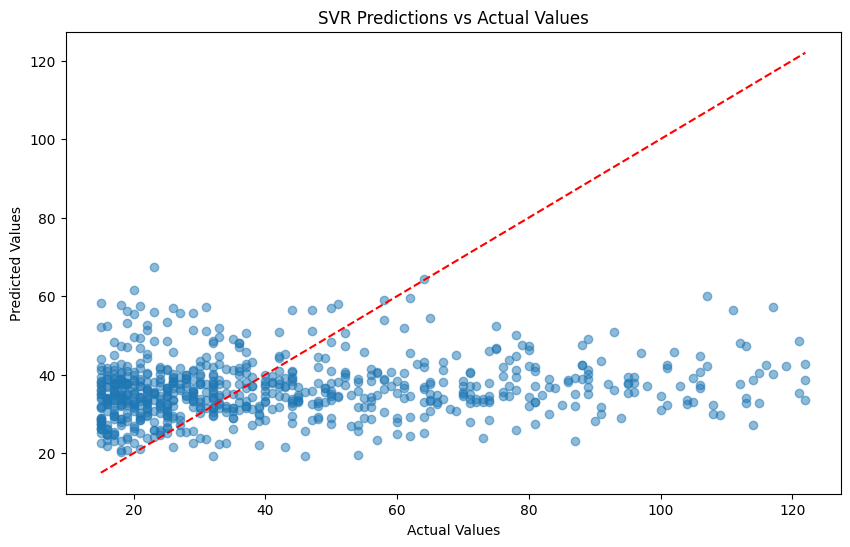

In [44]:
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("SVR Predictions vs Actual Values")
plt.show()
